In [13]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(data.table)
library(janitor)


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#Load in the avana bed file
setwd("../data")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4)

In [3]:
#First, load in the guide map so that we can figure out which guides are on the plus or minus strand
setwd("../data")
guide.map = read.table("21q4_Achilles_guide_map.csv", header = T, sep = ",") %>%
select(sgrna, genome_alignment) %>%
mutate(genome_alignment = gsub("..*_", "", genome_alignment)) %>%
rename("strand" = genome_alignment) %>%
distinct(sgrna, .keep_all = TRUE)

#Load in the Avana bed file to get positions for the ancestry-associated guides
#Also add the annotation information from guides.to.keep to the avana.bed matrix
#Also flip the start and end positions if the sgrna is on the minus strand
setwd("../data")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
mutate("true_start" = ifelse(strand %in% "+", start, end)) %>%
mutate("true_end" = ifelse(strand %in% "+", end, start))%>% #This line and the line above will create two new columns to flip the start and end if the sgrna is on the minus strand
select(chr, true_start, true_end, sgrna) %>%
rename("start" = true_start) %>%
rename("end" = true_end)

In [ ]:
#Filter the ccle variant calls so that it only includes SNPs that map to at least one sgRNA targeting sequence
#Now use bcftools to subset the big ccle snp matrix to only include SNPs in that range
#system(glue::glue("
#cd /home/jupyter/Ancestry/rfmix
#/home/jupyter/Ancestry/software/bcftools/bcftools view -R /home/jupyter/Ancestry/filtered_output/avana14/Avana14_filtering.bed split.all_chroms.maf.subset.reheader.vcf.gz -o /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.all.avana.guides.vcf.gz -Oz
#"))

In [6]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("../data")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
ccle.variant.calls = ccle.variant.calls %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))


#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
#system(glue::glue("
#cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
#/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.vcf.sample.names.txt
#"))

#Load in the sample names
setwd("../data")
sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(1)

#Add the sample names
ccle.variant.calls = ccle.variant.calls
colnames(ccle.variant.calls) = c("chr", "pos", "ref", "alt", sample.names)

In [7]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
  
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = ccle.variant.calls %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [8]:
#Assign the SNP ID as names for each vector

annotated.snp.in.guide.list = NULL
for(i in 1:length(snp.in.guide.list)){
        
    chromosome = avana.bed$chr[i] #get the chromosome which that guide targets
    
    #Now get a vector of snp positions and annotate the relative snp position vector with that information
    vector.to.annotate = snp.in.guide.list[[i]] #grab the vector that we need to annotate in this loop
    snp.vector = ccle.variant.calls %>% filter(chr %in% chromosome) %>% mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep = "")) %>% pull(snp) #make a vector that contains the snp information
    names(vector.to.annotate) = snp.vector #now apply that annotation to the vector of snp positions
    
    #Report the information outside of the loop
    annotated.snp.in.guide.list[[i]] = vector.to.annotate
    
}

names(annotated.snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [9]:
#Go through the list and remove the SNPs that don't map to a sgrna
pruned.snp.list = annotated.snp.in.guide.list %>%
lapply(function(x){
    vector = abs(x)
    val.to.return = vector[vector %in% 0:22]
    return(val.to.return)
}) %>% compact(1) #compact is part of the purrr package and will remove guides that don't have a SNP

In [10]:
#Now let's go through and create a nice data frame from this list.

snp.in.guide.df = NULL
for(i in 1:length(pruned.snp.list)){
    
   sgrna = pruned.snp.list[[i]] #this is a vector (normally length = 1, sometimes more with all of the snps that map to a vector)
   
    #If there is only one snp that maps to that sgrna, simply construct the vector and add it to the data frame
    #If there is more than one snp, then we need to get a little more fancy and construct a data frame first
    if(length(sgrna) == 1){
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        snp = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        vector.to.add = c(sgrna, snp, position) #Make a vector of values to add to the data frame
        snp.in.guide.df = rbind(snp.in.guide.df, vector.to.add) %>% data.frame() %>% #Then add that vector to the data frame
        rename("sgrna" = 1, "snp" = 2, "position" = 3)  
    } else {
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        sgrna.vector = rep(sgrna, length(pruned.snp.list[[i]])) #get a vector that contains the sgrna now, length = #snps
        snp.vector = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position.vector = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        df.to.add = cbind(sgrna.vector, snp.vector, position.vector) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3) #bind it all into a data frame
        snp.in.guide.df = rbind(snp.in.guide.df, df.to.add) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3)
 }
}

row.names(snp.in.guide.df) = NULL #remove the row names on the new df since they are useless

In [11]:
#First, load in the guide-level data
setwd("../data")
replicate.map = read.table("21q4_Achilles_replicate_map.csv", sep = ",", header = T)
guide.map = read.table("21q4_Achilles_guide_map.csv", sep = ",", header = T)
guide.level.data = fread("21q4_Achilles_logfold_change.csv", sep = ",", header = T, check.names = FALSE)

In [14]:
#Get a list of guides that we want to keep
guides.to.keep = snp.in.guide.df %>%
pull(sgrna)


#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
guide.level.data = guide.level.data %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% guides.to.keep) %>%
t() %>%
data.frame() %>% 
row_to_names(1, remove_rows_above = FALSE) %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value)) %>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”
`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Warning message:
“The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”
Using 'mean(value)' as value column. Use 'value.var' to override



In [15]:
#Process ccle.variant.calls so that it is ready for doing our analysis.
ccle.variant.calls.for.analysis = ccle.variant.calls %>%
mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep =""), .before = chr) %>%
select(-chr, -pos, -ref, -alt)

In [16]:
#Now loop through all of the variants in 'snp.in.guide.df' and calculate whether that SNP is associated with the guide 

pval.output = NULL
for(i in 1:nrow(snp.in.guide.df)){
  
    
    sgrna.of.interest = snp.in.guide.df$sgrna[i] #get the sgrna we are interested in
    snp.of.interest = snp.in.guide.df$snp[i] #get the snp we are interested in
    
    #First get two vectors of cell line IDs with or without the SNP
    lines.with.snp = ccle.variant.calls.for.analysis %>%
    filter(snp %in% snp.of.interest) %>%
    select(-snp) %>%
    apply(2, as.numeric) %>%
    .[. > 0] %>%
    names(.)

    lines.without.snp = setdiff(colnames(ccle.variant.calls.for.analysis[2:ncol(ccle.variant.calls.for.analysis)]), lines.with.snp)

    
    #Get vectors of values for the sgrna scores for cell lines with or without the snp
    with.snp.scores = guide.level.data %>%
    select(sample, all_of(sgrna.of.interest)) %>%
    rename("sgrna" = 2) %>%
    filter(sample %in% lines.with.snp) %>%
    pull(sgrna) %>%
    as.numeric(.)
    
    without.snp.scores = guide.level.data %>%
    select(sample, all_of(sgrna.of.interest)) %>%
    rename("sgrna" = 2) %>%
    filter(sample %in% lines.without.snp) %>%
    pull(sgrna) %>%
    as.numeric(.)
    
    
    #Perform a t-test
    
    if(length(with.snp.scores) >= 10 && length(without.snp.scores) >= 10){
    pval = t.test(with.snp.scores, without.snp.scores, alternative = "two.sided")$p.value } else {
    pval = 1
    }
    
    
    #return the data to the object outside of the loop
    pval.output = c(pval.output, pval)
}

In [17]:
#bind the p-values back into the main data frame and calculate fdr
final.df = snp.in.guide.df %>%
mutate(pval = pval.output) %>%
mutate("fdr" = p.adjust(pval.output, method = "BH", n = length(pval.output))) %>%
mutate(position = factor(position, levels = 0:22)) %>%
rename("pval" = 4, "fdr" = 5) 

In [19]:
#Write this as an output file
setwd("../output")
write.table(final.df, "snv_position_single_guide_finaldf.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [21]:
#Load in the John Doench data
setwd("../data")
doench.data = read.table("Doench_Data.txt", sep = "\t", header = T)

In [22]:
#Calculate the median pval at each site
doench.median.pvals = doench.data %>%
group_by(Position) %>%
summarise(median(t.test.p.value)) %>%
data.frame() %>%
rename("position" = 1, "median_pval" = 2) %>%
mutate(index = seq(from = 0, to = 19, by = 1))

Warning message:
“Removed 255 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 255 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


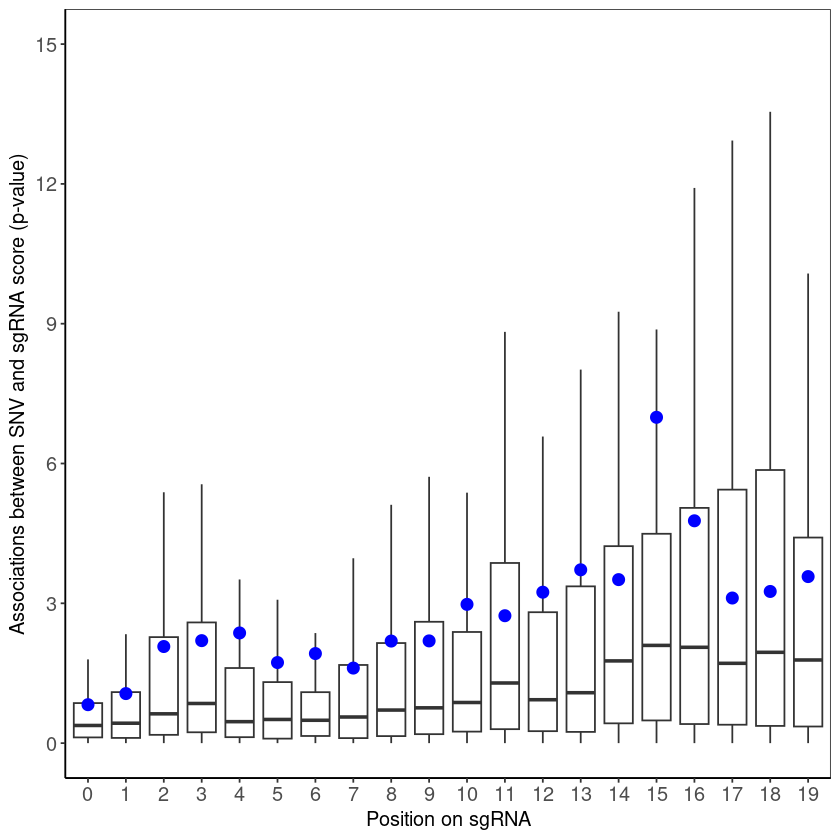

In [23]:
#Now plot the plot
final.df %>%
filter(position %in% c(0:19)) %>%
ggplot() +
geom_boxplot(outlier.shape = NA, aes(x = position, y = -log10(pval))) +
geom_point(data = doench.median.pvals, shape = 19, size = 3, color = "blue", aes(x = position, y = -log10(median_pval))) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12,)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_y_continuous(breaks = seq(0, 15, by = 3), limits = c(0,15)) +

ylab("Associations between SNV and sgRNA score (p-value)") +
xlab("Position on sgRNA")


#Export it to the google bucket
setwd('../output')
ggsave("figure_3e.pdf", width = 3.5, height = 2)

In [27]:
#Write the dataset that went into making this plot
fig_3e_df_for_export = final.df %>%
filter(position %in% c(0:19))

setwd("../output")
write.table(fig_3e_df_for_export, "figure3_plotting_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [24]:
#Calculate the number of guides where there is a significant association between a SNV and that guide
number.with.snp = final.df %>%
filter(fdr < 0.05) %>%
pull(sgrna) %>%
unique() %>%
length()

#Calculate some values
num.unique.snippy.guides = final.df$sgrna %>% unique() %>% length()
fraction.of.all.guides = number.with.snp/nrow(avana.bed)
fraction.of.snippy.guides = number.with.snp/num.unique.snippy.guides

In [25]:
#First, collapse the final.df data so that it is in the same format as the doench.median.pvals dataset
final.df.medians = final.df %>%
select(position, pval) %>%
group_by(position) %>%
summarise(median(pval))%>%
rename("median_pval" = 2) %>%
mutate(position = as.numeric(position))

final.doench.medians = doench.median.pvals %>%
select(-position) %>%
rename("doench_median_pval" = median_pval, "position" = index)


#Merge the two datasets together
ours.doench.merged = inner_join(final.df.medians, final.doench.medians, by = "position")


#Perform correlation and get a p-val to report in the paper
cor.test(ours.doench.merged$median_pval, ours.doench.merged$doench_median_pval)


	Pearson's product-moment correlation

data:  ours.doench.merged$median_pval and ours.doench.merged$doench_median_pval
t = 3.6823, df = 17, p-value = 0.001847
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3038316 0.8600971
sample estimates:
      cor 
0.6661149 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


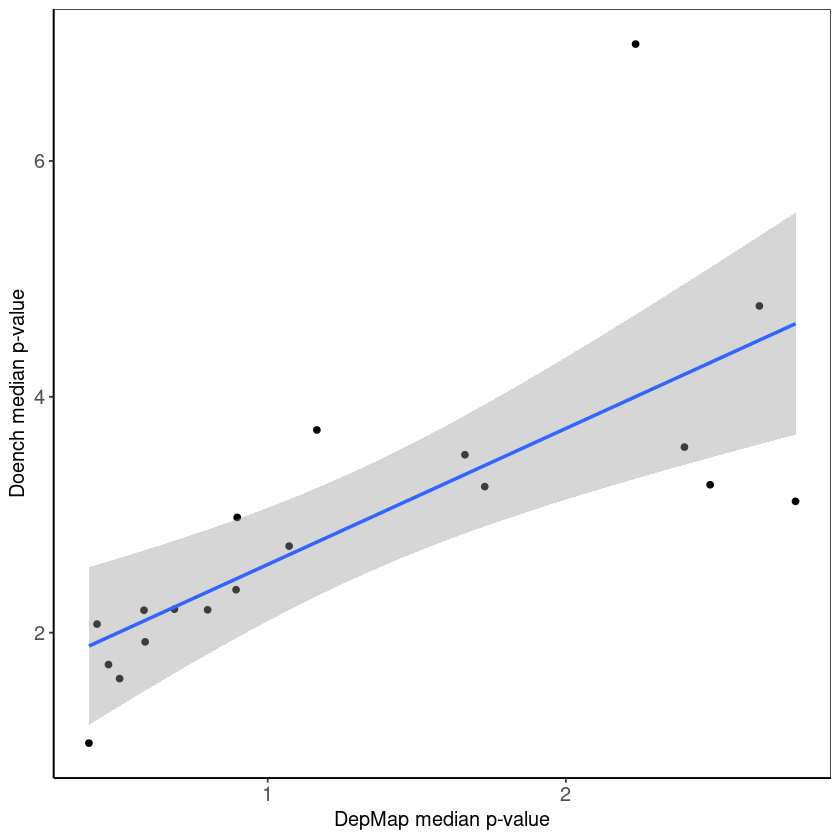

In [26]:
#Generate a correlation plot
ours.doench.merged %>%
ggplot(aes(x = -log10(median_pval), y = -log10(doench_median_pval))) +
geom_point() +
geom_smooth(method=lm) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

xlab("DepMap median p-value") +
ylab("Doench median p-value") 


#Export it to the google bucket
setwd("../output")
ggsave("supplemental_figure_8.pdf", width = 4, height = 4)

In [28]:
#Write the dataset that went into making this plot
sup_fig_8_df_for_export = ours.doench.merged %>%
filter(position %in% c(0:19))

setwd("../output")
write.table(ours.doench.merged, "supplemental_figure_8_ours_doench_merged.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)